# Análisis dataset WiDS2018 Fundación Bill & Melinda Gates

#### Autor: Javier Cano Montero

El objetivo del siguiente trabajo consiste en crear un modelo capaz de predecir el género de una persona según sus respuestas en una encuesta realizada en la India. La temática de la encuesta es acerca del uso de servicios financieros y el móvil.

Comencemos importando las librerías que vamos a utilizar en el desarrollo:
- pandas para manejar los datos
- numpy para la representación matemática
- matplotlib para hacer gráficos
- scikit-learn para el modelado del predictor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as GBT
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_curve, auc

Leemos los datos de train en un dataframe, indicando que el índice de cada observación está indicado en la columna 'train_id'.

In [2]:
train = pd.read_csv("../data/train.csv",index_col='train_id', low_memory=False)

Extraemos la variable a predecir 'is_female' y la guardamos en la variable **y**. A continuación la eliminamos del dataframe 'train' ya que no la usaremos más.

In [3]:
y = train['is_female']
y = y.astype('int')
train.drop('is_female', axis=1, inplace=True)

Antes de empezar, vamos a ver cómo de balanceadas son las dos clases. En el enunciado se nos dice que la muestra es representativa de la demografía. Vemos que el 53% de los encuestados son mujeres y el 47% son hombres. Esto nos indica que el conjunto está balanceado.

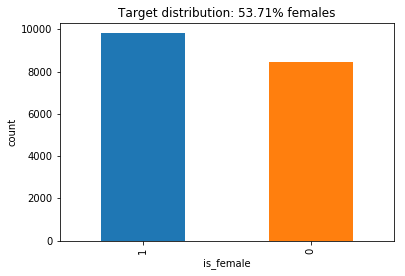

In [4]:
y.value_counts().plot(kind='bar')
plt.xlabel('is_female')
plt.ylabel('count')
plt.title('Target distribution: ' + "{0:.2f}".format((len(y[y==1])/len(y))*100) + '% females')
plt.show()

El dataframe 'train' tiene 18.255 observaciones (encuestados) con 1.233 variables a tener en cuenta.

In [5]:
train.shape

(18255, 1233)

## Feature engineering

### Variables numéricas

Según el diccionario de datos las únicas variables numéricas existentes en el dataset son las siguientes. 

In [6]:
numeric_variables = ['AA17','DG1','DG8a','DG8b','DG9a','DG9b','DG9c','DL8','DL11','MT1','MT6C',
                     'FF7_1','FF7_2','FF7_3','FF7_4','FF7_5','FF7_6','FF7_7','FF7_96',
                     'FF8_1','FF8_2','FF8_3','FF8_4','FF8_5','FF8_6','FF8_7','FF8_96',
                     'MM23','IFI18','FB13','FB14','FB15','RI5_1','RI5_2','RI5_3']

Comprobamos que todas las variables identificadas están en el dataset, pero comprobamos que faltan alguns:

In [7]:
[i for i in numeric_variables if i not in train.columns]

['AA17', 'RI5_1', 'RI5_2', 'RI5_3']

Según el diccionario, las variables AA17, RI5_1, RI5_2 y RI5_3 son números de teléfono, así que no aportarían nada al análisis.

Nos quedamos con las variables que sí existen y las separamos en numéricas y categóricas.

In [8]:
numeric_variables = [i for i in train.columns if i in numeric_variables]
categorical_variables = [i for i in train.columns if i not in numeric_variables]

Tenemos 31 variables numéricas.

In [9]:
len(numeric_variables)

31

En el diccionario de datos se puede observar que para las variables numéricas la respuesta 99 implica un NS/NC, por lo que lo trataremos con un valor no disponible *null* y eliminamos las variables que estén vacías.

In [10]:
train[numeric_variables] = train[numeric_variables].replace(99,np.nan)
train_nvars = train[numeric_variables].dropna(axis=1, how='all')

Podemos ver que tras este proceso, se puede eliminar la variable MM23, ya que solo contiene *nulls*.

In [11]:
[i for i in numeric_variables if i not in train_nvars.columns]

['MM23']

Procedemos a actualizar la lista de variables numéricas.

In [12]:
numeric_variables = [i for i in train_nvars.columns if i in numeric_variables]

Finalmente, tras todo el proceso nos quedamos con 30 variables numéricas.

In [13]:
len(numeric_variables)

30

Una vez seleccionadas las 30 variables numéricas que vamos a utilizar para entrenar el modelo, necesitamos manejar los valores faltantes o *nulls*. Veamos cómo se distribuyen.

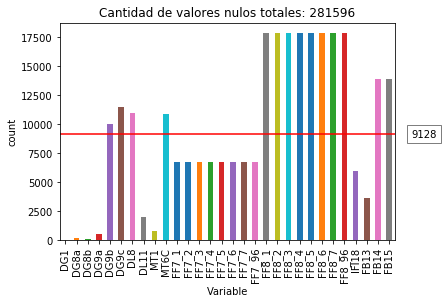

In [14]:
pd.isna(train_nvars).sum().plot(kind='bar')
plt.title('Cantidad de valores nulos totales: ' + str(pd.isna(train_nvars).values.sum()))
plt.axhline(round(train_nvars.shape[0]/2), color="red")
plt.text(31, round(train_nvars.shape[0]/2), "9128", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5))
plt.xlabel('Variable')
plt.ylabel('count')
plt.show()

Vemos que hay algunas variables que tienen más del 50% de observaciones como *nulls*. Estas variables nos está disminuyendo la calidad del conjunto de datos, así que es mejor eliminarlas del análisis.

In [15]:
train_nvars = train_nvars.dropna(thresh=round(train_nvars.shape[0]/2), axis=1)

Podemos ver que tras este proceso, se puede eliminar las variables DG9\*, DL8, MT6C, FF8\*, FB14 y FB15, ya que tenían más del 50% de valores a *null*.

In [16]:
[i for i in numeric_variables if i not in train_nvars.columns]

['DG9b',
 'DG9c',
 'DL8',
 'MT6C',
 'FF8_1',
 'FF8_2',
 'FF8_3',
 'FF8_4',
 'FF8_5',
 'FF8_6',
 'FF8_7',
 'FF8_96',
 'FB14',
 'FB15']

Procedemos a actualizar la lista de variables numéricas.

In [17]:
numeric_variables = [i for i in train_nvars.columns if i in numeric_variables]

Nos quedamos con 16 variables numéricas.

In [18]:
len(numeric_variables)

16

Para rellenar los *null* en las variables restantes vamos a proceder a imputarlos. Imputar un dato es rellenar ese faltante según un criterio. Los criterios más comunes son elegir un valor constante (0 por ejemplo), la media o la mediana de la columna. He decidido que se imputarán los valores a la media.

In [19]:
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
train_nvars = pd.DataFrame(imp_num.fit_transform(train_nvars[numeric_variables]),columns=numeric_variables)

### Variables categóricas

Hora de trabajar con las categóricas. Comenzamos con 1.202 variables categóricas.

In [20]:
len(categorical_variables)

1202

Eliminamos aquellas que están vacías de información (completamente *null*)

In [21]:
train_cvars = train[categorical_variables].dropna(axis=1, how='all')

Ejecutando la siguiente línea puede verse cuáles son las variables que se eliminan. Por claridad no se muestran en el análisis.

In [22]:
#[i for i in categorical_variables if i not in train_cvars.columns]

Actualizamos el listado de variables categóricas.

In [23]:
categorical_variables = [i for i in train_cvars.columns if i not in numeric_variables]

Y vemos que ahora tenemos 1.152 variables categóricas. Todas con información, aunque siguen manteniendo valores *null*.

In [24]:
len(categorical_variables)

1152

Para imputar los valores *null* de las variables categóricas usaremos el valor de la clase más frecuente.

In [25]:
imp_cat = SimpleImputer(strategy="most_frequent")
train_cvars = pd.DataFrame(imp_cat.fit_transform(train_cvars[categorical_variables]),columns=categorical_variables)

Al haber imputado, puede que alguna variable con una alta tasa de *nulls* ahora contenga un único valor, por lo que no aportaría nada al modelo. Vamos a proceder a eliminar estas variables.

In [26]:
for col in train_cvars.columns:
    if len(train_cvars[col].unique()) == 1:
        train_cvars.drop(col,inplace=True,axis=1)

Ejecutando la siguiente línea puede verse cuáles son las variables que se eliminan. Por claridad se deja la línea comentada.

In [27]:
#[i for i in categorical_variables if i not in train_cvars.columns]

Actualizamos el listado de variables categóricas.

In [28]:
categorical_variables = [i for i in train_cvars.columns if i not in numeric_variables]

Y vemos que ahora tenemos 1.076 variables categóricas.

In [29]:
len(categorical_variables)

1076

Ahora crearemos un imputador con las variables categóricas definitivas de forma que podamos aplicarlo posteriormente en el conjunto de test. Para ello reutilizaremos el creado anteriormente pero entrenando con las variables finales.

In [30]:
imp_cat.fit(train_cvars[categorical_variables])

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)

### Construyendo un conjunto de entrenamiento 'limpio'

Tras toda esta tarea de limpieza ya tenemos nuestro conjunto "train" final. Solo hay que concatenar los datasets con las 16 variables numéricas y las 1076 categóricas. También actualizamos la lista de variables que usaremos para entrenar el modelo de cara a poder seleccionarlas luego en el conjunto 'test'.

In [31]:
train = pd.concat([train_nvars,train_cvars], axis=1, sort=False)
train_variables = numeric_variables+categorical_variables

In [32]:
train.shape

(18255, 1092)

El framework scikit-learn está diseñado para utilizar únicamente números. Algunas variables categóricas son strings, por lo que si procedemos a entrenar el modelo con el dataframe actual nos dará un error. Para poder continuar necesitamos realizar un encoding sobre el dataframe 'train'. </br> Este proceso consiste en crear variables sintéticas que indican que una clase determinada en una variable categórica es la elegida. El valor de estas variables sintéticas será 1 para la clase de la observación y 0 para la otra. Por ejemplo, si una variable 'ELEGIR' de tipo categórica tiene las clases SI y NO, se crearán dos variables sintéticas 'ELEGIR_SI' y 'ELEGIR_NO'. Si en la observación original la variable tenía el valor 'SI', 'ELEGIR_SI'=1 y 'ELEGIR_NO'=0. </br> También se coloca el flag de control handle_unkown='ignore' ya que el conjunto de 'test' puede tener respuestas no contempladas en el conjunto de 'train'. Este flag hace que se cree una nueva clase 'unkown' en caso de que ocurra.

In [33]:
enc = OneHotEncoder(handle_unknown='ignore')

In [34]:
X = enc.fit_transform(train)

Se puede ver que el proceso de encoding mantiene el número de observaciones, pero dispara (como era de esperar) el número de variables.

In [35]:
X.shape

(18255, 7464)

## Entrenando el modelo

El conjunto 'test' suministrado no contiene etiquetado, así que para validar el modelo que construyamos es necesario obtener un conjunto de validación sobre el que obtener métricas. Este conjunto (X_validation) tendrá el 30% del conjunto 'train' original y crearemos un nuevo conjunto de entrenamiento (X_train).

In [36]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.30, random_state=77)

In [37]:
X_train.shape

(12778, 7464)

Para predecir la variable objetivo 'is_female', vamos a construir un modelo de clasificación de gradiente descendente. Este modelo es un ensamblado de 250 árboles de decisión con muy poca profundidad (3), pero que en conjunto predecirán correctamente (espero) la variable objetivo.

In [38]:
params = {'n_estimators': 250, 'max_depth': 3,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3, 'verbose': 1}

In [39]:
model=GBT(**params)
model.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3674            6.69m
         2           1.3550            5.84m
         3           1.3428            5.56m
         4           1.3309            5.42m
         5           1.3192            5.31m
         6           1.3078            5.24m
         7           1.2966            5.18m
         8           1.2856            5.10m
         9           1.2747            5.04m
        10           1.2641            5.00m
        20           1.1681            4.68m
        30           1.0876            4.47m
        40           1.0196            4.24m
        50           0.9617            4.04m
        60           0.9119            3.83m
        70           0.8688            3.62m
        80           0.8313            3.42m
        90           0.7985            3.21m
       100           0.7698            3.00m
       200           0.6032           59.68s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=3,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

## Validación del modelo

Una vez entrenado el modelo predeciremos la variable objetivo en el conjunto de validación y obtendremos unas métricas para ver cómo de bueno es el predictor.

In [40]:
y_pred = model.predict(X_validation)

El modelo tiene un 89.6% de exactitud en la predicción sobre el conjunto de validación, es decir, acierta 9 de cada 10 predicciones. Este modelo parece bueno, pero la exactitud no es suficiente para saberlo, ya que si las dos clases a predecir están desbalanceadas podría darse el caso de que prediga muy bien la clase mayoritaria pero no la minoritaria.

In [41]:
print("Exactitud:\t"+str(accuracy_score(y_validation,y_pred)))

Exactitud:	0.8962935913821435


Para asegurarnos que nuestro clasificador está funcionando correctamente, vamos a obtener las métricas de precisión y recuperación. Para explicar estas métricas voy a recurrir a un ejemplo:
- Precisión. ¿Cuántas mujeres son realmente mujeres en mi predición?
- Recuperación. ¿Cuántas mujeres he recuperado del total de mujeres?

Se puede ver que en ambas métricas el resultado es aproximadamente un 90%, por lo que podemos decir que el modelo es muy bueno.

In [42]:
print("Precisión:\t"+str(precision_score(y_validation,y_pred)))
print("Recuperación:\t"+str(recall_score(y_validation,y_pred)))

Precisión:	0.9018194301407484
Recuperación:	0.9030594706084565


Además de las métricas, vamos a proceder a graficar la curva ROC. Podemos ver que la métrica del AUC es consistente con las ya obtenidas y es también aproximadamente un 90%.

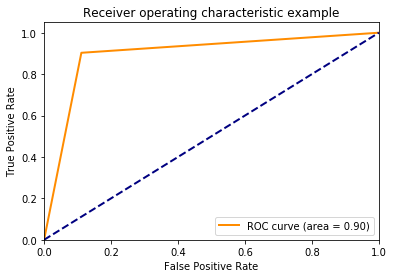

In [43]:
fpr,tpr,_=roc_curve(y_validation,y_pred)

score = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

El modelo en sí nos permite predecir el género del encuestado, pero además podemos saber en qué variables se ha fijado el modelo para tomar esa decisión calculando la importancia.

(Se puede modificar el número de variables a dibujar cambiando el valor de N)

In [44]:
N = 10

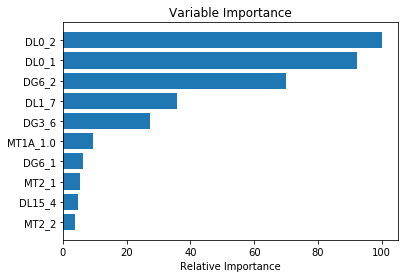

In [45]:
feature_names = enc.get_feature_names(train_variables)

# Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

feature_importance[sorted_idx][-1:]

feature_names[sorted_idx]

pos = np.arange(N) + .5
plt.barh(pos, feature_importance[sorted_idx][-N:], align='center')
plt.yticks(pos, feature_names[sorted_idx][-N:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

De las variables más importantes se puede concluir que el modelo decide que un encuestado es del género femenino si es la "esposa" del cabeza de familia (DG6_2), "en los últimos 12 meses ha sido ama o amo de casa" (DL1_7), "es viuda o viudo" (DG3_6)...

## Creando un fichero submission

Otro requisito era crear un fichero 'submission.csv' en el mismo formato que 'sample_submission.csv', para ello leemos el fichero 'test'.csv'.

In [46]:
test = pd.read_csv("../data/test.csv",index_col='test_id', low_memory=False)

Seleccionamos las mismas variables usadas en el entrenamiento del modelo.

In [47]:
test = test[train_variables]

Imputamos los *null* de las variables numéricas a la media del conjunto de entrenamiento.

In [48]:
test_nvars = pd.DataFrame(imp_num.transform(test[numeric_variables]),columns=numeric_variables)

Imputamos los *null* de las variables categóricas a la clase más frecuente del conjunto de entrenamiento.

In [49]:
test_cvars = pd.DataFrame(imp_cat.transform(test[categorical_variables]),columns=categorical_variables)

Concatenamos las variables numéricas y categóricas del conjunto de 'test'

In [50]:
test = pd.concat([test_nvars,test_cvars], axis=1, sort=False)

Realizamos el encoding de las variables categóricas de entrenamiento. En caso de encontrar nuevas clases las asignará a una clase 'unkown'.

In [51]:
X_test = enc.transform(test)

Predecimos la probabilidad de que el encuestado sea hombre o mujer usando el modelo creado y validado.

In [52]:
y_pred = model.predict_proba(X_test)

Generamos un dataframe con el contenido requerido en el ejercicio y lo guardamos en *data/submission.csv*.

In [53]:
submission = pd.DataFrame()
submission['test_id']=range(0,len(y_pred))
submission['is_female']=y_pred[:,1]
submission.to_csv('../data/submission.csv', index=False)

# Anexos

## Diccionario de las variables importantes

DL0. Who is the main income earner in your household?"1=Myself, 2=Somebody else"

DG6.How are you related to the household head? "1=Myself
2=Spouse
3=Son/Daughter
4=Father/Mother
5=Sister/Brother
6=Grandchild
7=Other relative
9=Other non-relative
99=DK"


DL1. In the past 12 months, were you mainly...? "1=Working full-time for a regular salary
2=Working part-time for a regular salary
3=Working occasionally, irregular pay (whenever the work is available)
4=Working per season (e.g., only during the harvest season)
5=Self-employed, working for yourself
6=Not working but looking for a job
7=Housewife or stay-at-home husband doing household chores
8=Full-time student
9=Not working because of retirement
10=Not working because of sickness, disability, etc.
96=Other(Specify)
99=DK"


DG3. What is your marital status? "1=Singe/ Not married 
2=Polygamously married (i.e., has multiple spouses)
3=Monogamously married
4=Divorced
5=Separated
6=Widow/widower
7=Living together with my partner but not married
8=Living together/cohabitating 
96=Other (Specify)
99=DK"


MT1A.Who decides on who should have a phone in your household? "1=Myself
2=My spouse 
3=My parents/guardian
4=My child (children) 
5=Brother
8=Sister
99=DK"


DL15.What is the highest grade that the female head/spouse completed? "1=Primary or below, or not literate
2=Middle
3=Secondary or higher 
4=No female head/spouse"


MT2.Do you personally own a mobile phone? "1=Yes
2=No"


## Distribución de las variables usadas para entrenar

A continuación se muestran los histogramas de las variables numéricas.

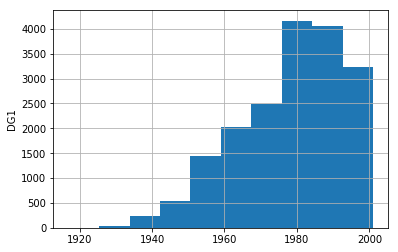

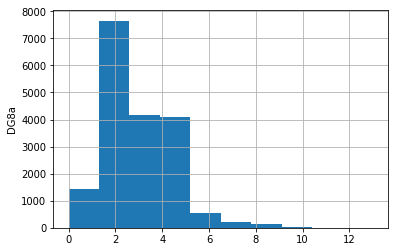

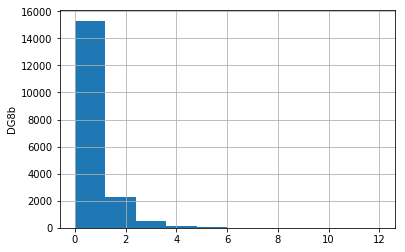

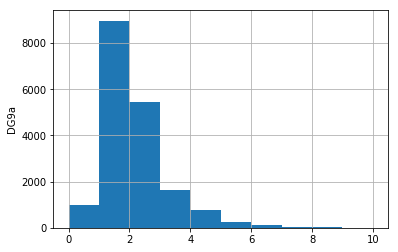

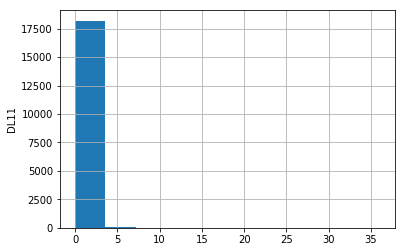

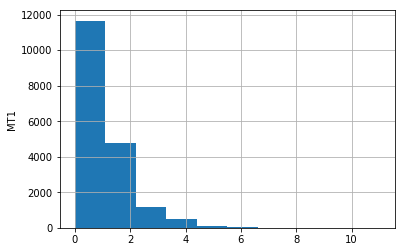

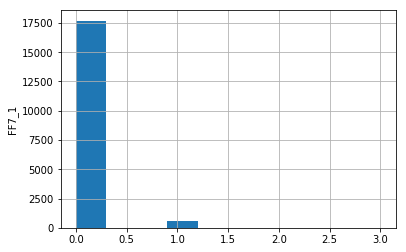

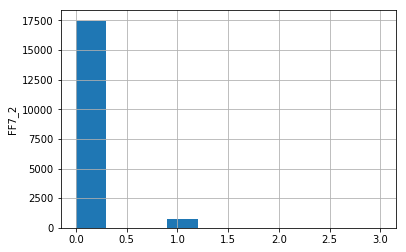

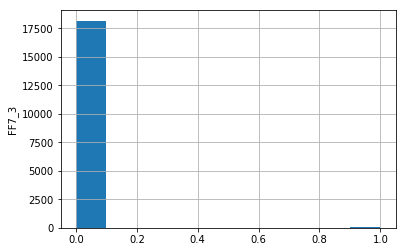

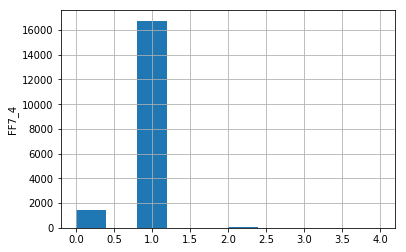

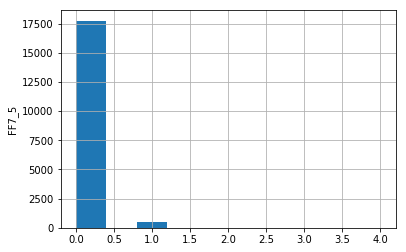

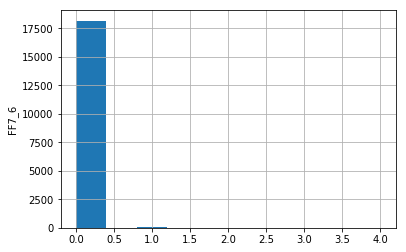

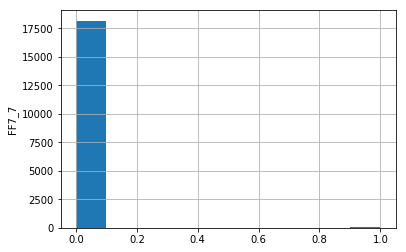

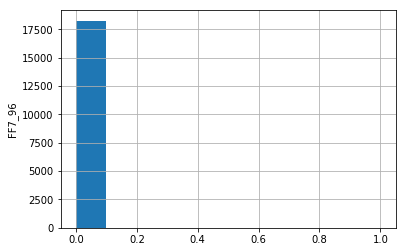

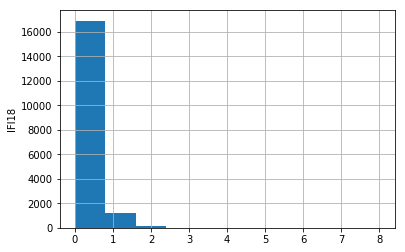

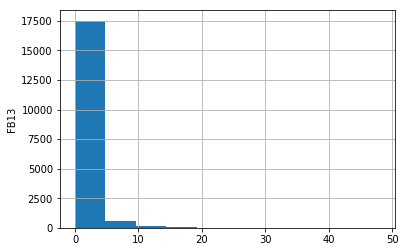

In [54]:
for var in numeric_variables:
    train[var].hist()
    plt.ylabel(var)
    plt.show()

A continuación se deja indicado el código para graficar las 1.076 variables categóricas.

In [55]:
#for var in categorical_variables:
#    train[var].value_counts().plot(kind='bar')
#    plt.ylabel(var)
#    plt.show()